## Описание:
Данный проект направлен на анализ рынка подержанных автомобилей в России с использованием данных, собранных с популярного автомобильного портала carro.ru.

# Задачи:

* Марка и модель автомобиля
* Год выпуска
* Пробег
* Тип кузова
* Тип двигателя (бензин, дизель, гибрид)
* Мощность двигателя
* Коробка передач (автомат, механика, вариатор)
* Цена

## Обработка и очистка данных:
* Преобразование собранных данных в удобный для анализа формат.
* Очистка данных от некорректных значений, дубликатов и выбросов.
* Обработка пропущенных значений с использованием подходящих стратегий (удаление, заполнение медианой/средним, импутация).

## Анализ данных: Проведение разведочного анализа данных (EDA) для выявления основных тенденций на рынке:

* Распределение цен на автомобили в зависимости от марки, модели, года выпуска, пробега и других параметров.
* Влияние технических характеристик (мощность двигателя, тип коробки передач) на стоимость автомобилей.
* Визуализация данных: Создание интерактивных визуализаций (с использованием библиотек Matplotlib, Seaborn)
* Гистограммы распределения цен Диаграммы рассеяния, показывающие зависимость цены от пробега и года выпуска
* Интерактивный dashboards для удобного анализа данных.

In [124]:
#Импортируем библиотеки
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
plt.figure(figsize=(11,20))

<Figure size 1100x2000 with 0 Axes>

<Figure size 1100x2000 with 0 Axes>

In [3]:
#Указываем путь к JSON файлу с данными
url = '/home/max/git/maxtyrsa-1/Анализ рынка подержанных автомобилей: парсинг данных с carro.ru/carro.json'

In [4]:
#Загружаем JSON данные из указанного файла в DataFrame
df = pd.read_json(url)

In [5]:
#Выпрямляем вложенные данные из поля 'tech_specs'
tech = pd.json_normalize(df['tech_specs'])

In [6]:
# Удаляем исходное поле 'tech_specs' из DataFrame
df = df.drop('tech_specs', axis=1)

In [7]:
#Объединяем исходный DataFrame с выпрямленными данными
df = pd.concat([df, tech], axis=1)

In [8]:
#Приведение названий столбцов к общему стилю
df = df.rename(columns={'Год:': 'year', 'Коробка:': 'transmission', 'Пробег:': 'mileage', 'Объем:': 'volume', 'Мощность:': 'power', 'Двигатель:': 'engine', 'Тип кузова:': 'body_type', 'Привод:': 'drive', 'Владельцы:': 'owners'})

In [24]:
df.dtypes

name             object
price             int64
url              object
year              int64
transmission     object
mileage           int64
volume          float64
power             int64
engine           object
body_type        object
drive            object
owners           object
age               int64
model            object
dtype: object

In [9]:
#Преобразуем столбец year в datetime и вычислик количество лет автомобилей в годах и добавим столбец age
df['year'] = df.year.astype('int')
df['age'] = pd.to_datetime('now').year - df.year

In [10]:
# Добавим строки с названием и моделью автомобилей
df['name'] = df.url.str.split('/').str[5]
df['model'] = df.url.str.split('/').str[6]

In [11]:
# Применение регулярных выражений для замены значений
df['price'] = df['price'].str.replace(r'\D+', '', regex=True).astype('int')
df['mileage'] = df['mileage'].str.replace(r'\D+', '', regex=True).astype('int')
df['volume'] = df['volume'].str.replace(' л', '').str.replace('\xa0', '').astype('float')
df['power'] = df['power'].str.replace(r'\D+', '', regex=True).astype('int')

In [92]:
df.drop(columns=['url'], axis=1, inplace=True)

In [93]:
df.head()

,name,price,year,transmission,mileage,volume,power,engine,body_type,drive,owners,age,model
0,41,299000,2010,1,145543,1.6,120,0,11,1,2,14,9
1,8,399000,2012,3,180066,1.6,109,0,8,1,2,12,82
2,32,399000,2013,3,137622,1.8,128,0,1,1,1,11,336
3,29,419000,2015,3,117128,1.6,105,0,9,1,2,9,184
4,17,419000,2013,3,140844,2.4,127,0,1,2,2,11,156


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9921 entries, 0 to 9920
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          9921 non-null   object 
 1   price         9921 non-null   int64  
 2   url           9921 non-null   object 
 3   year          9921 non-null   int64  
 4   transmission  9921 non-null   object 
 5   mileage       9921 non-null   int64  
 6   volume        9921 non-null   float64
 7   power         9921 non-null   int64  
 8   engine        9921 non-null   object 
 9   body_type     9921 non-null   object 
 10  drive         9921 non-null   object 
 11  owners        9921 non-null   object 
 12  age           9921 non-null   int64  
 13  model         9921 non-null   object 
dtypes: float64(1), int64(5), object(8)
memory usage: 1.1+ MB


In [16]:
df.describe()

,price,year,mileage,volume,power,age
count,9.921000e+03,9921.000000,9921.000000,9921.000000,9921.000000,9921.000000
mean,1.341898e+06,2014.411551,120228.247354,2.448100,202.915634,9.588449
std,6.810405e+05,3.508208,42286.211396,0.878504,72.637462,3.508208
min,2.990000e+05,2004.000000,7.000000,1.000000,80.000000,0.000000
25%,8.690000e+05,2012.000000,90968.000000,2.000000,150.000000,7.000000
50%,1.179000e+06,2014.000000,127534.000000,2.100000,184.000000,10.000000
75%,1.589000e+06,2017.000000,149650.000000,3.000000,245.000000,12.000000
max,6.999000e+06,2024.000000,373018.000000,6.200000,575.000000,20.000000


In [17]:
df.isna().sum()

name            0
price           0
url             0
year            0
transmission    0
mileage         0
volume          0
power           0
engine          0
body_type       0
drive           0
owners          0
age             0
model           0
dtype: int64

In [21]:
df.duplicated().sum()

0

/tmp/ipykernel_3166/4099152240.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax);


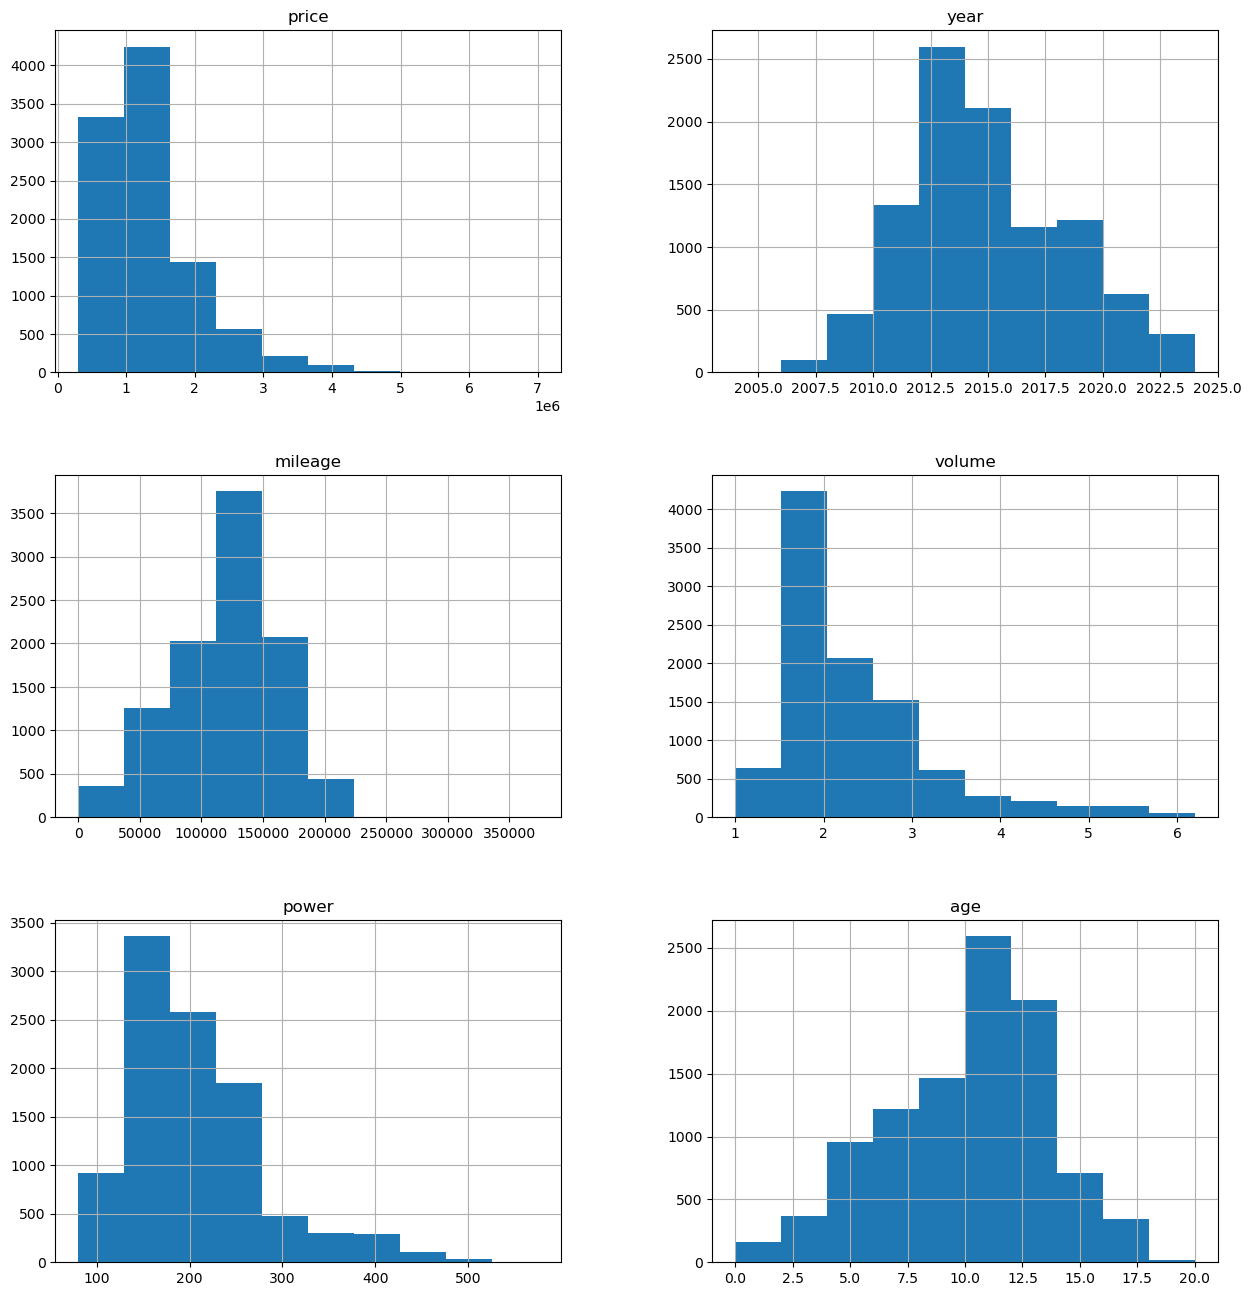

In [12]:
fig = plt.figure(figsize = (15,16))
ax = fig.gca()
df.hist(ax = ax);

#### На этом изображении показаны шесть гистограмм, каждая из которых представляет распределение отдельной переменной, связанной с данными о транспортном средстве:

##### цена: 
Распределение цен сильно смещено вправо, большинство цен сосредоточено в нижнем диапазоне и длинный хвост в сторону более высоких цен. Это указывает на множество менее дорогих автомобилей и меньшее количество очень дорогих.

##### год: 
Распределение по годам показывает пик около 2012-2015, что говорит о том, что многие автомобили в этом наборе данных относятся к той эпохе. Оно демонстрирует относительно равномерное распределение между 2005-2023.

##### пробег: 
Пробег показывает распределение с перекосом вправо. Это означает, что есть много автомобилей с небольшим пробегом и меньше с очень большим пробегом.

##### объем: 
Объем двигателя показывает несколько пиков, что предполагает несколько популярных размеров двигателя. Кажется, пик находится около 1,5-2,0 литров. Он смещен вправо.

##### мощность: 
Мощность двигателя показывает распределение, смещенное вправо. Многие транспортные средства имеют меньшую мощность, а некоторые имеют значительно большую мощность.

##### возраст: 
Гистограмма возраста показывает в основном симметричное распределение. Пик приходится на 10 лет, что говорит о большом количестве 10-летних автомобилей.

##### В целом: Гистограммы дают визуальное представление распределения ключевых характеристик набора данных транспортного средства. Правильная асимметрия в нескольких гистограммах (цена, пробег, объем, мощность) предполагает, что многие значения сосредоточены на нижнем конце шкалы, в то время как меньшее количество значений простирается на верхний конец. Это распространенная закономерность во многих наборах данных этого типа.

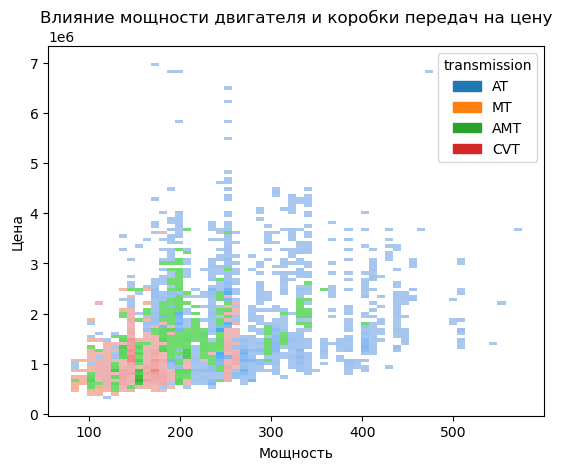

In [25]:
sns.histplot(data=df, x='power', y='price', hue='transmission');
plt.title('Влияние мощности двигателя и коробки передач на цену');
plt.xlabel('Мощность');
plt.ylabel('Цена');
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})


##### Общая тенденция: 
наблюдается общая тенденция к росту, предполагающая, что с ростом мощности двигателя цена также имеет тенденцию к росту. Это ожидаемо.

##### 
Тип трансмиссии: Различные цвета позволяют сравнивать цену и мощность для разных типов трансмиссии. Вы можете увидеть, какие типы трансмиссии более распространены при разных уровнях мощности и цены. Например, кажется, что автоматические трансмиссии (AT) более распространены в более высоких ценовых диапазонах и с более высокой выходной мощностью.

##### Кластеризация: 
Точки данных распределены неравномерно, что подразумевает кластеризацию схожих автомобилей на основе цены и мощности. Определенные комбинации мощности и цены встречаются чаще, чем другие.

##### Выбросы: 
некоторые точки данных разбросаны в областях с более низкой плотностью, что потенциально указывает на выбросы (транспортные средства с необычными сочетаниями цены и мощности для своего типа трансмиссии).

In [83]:
name_count = df.groupby('name', as_index=False).agg({'price': 'count'}).sort_values('price', ascending=False)

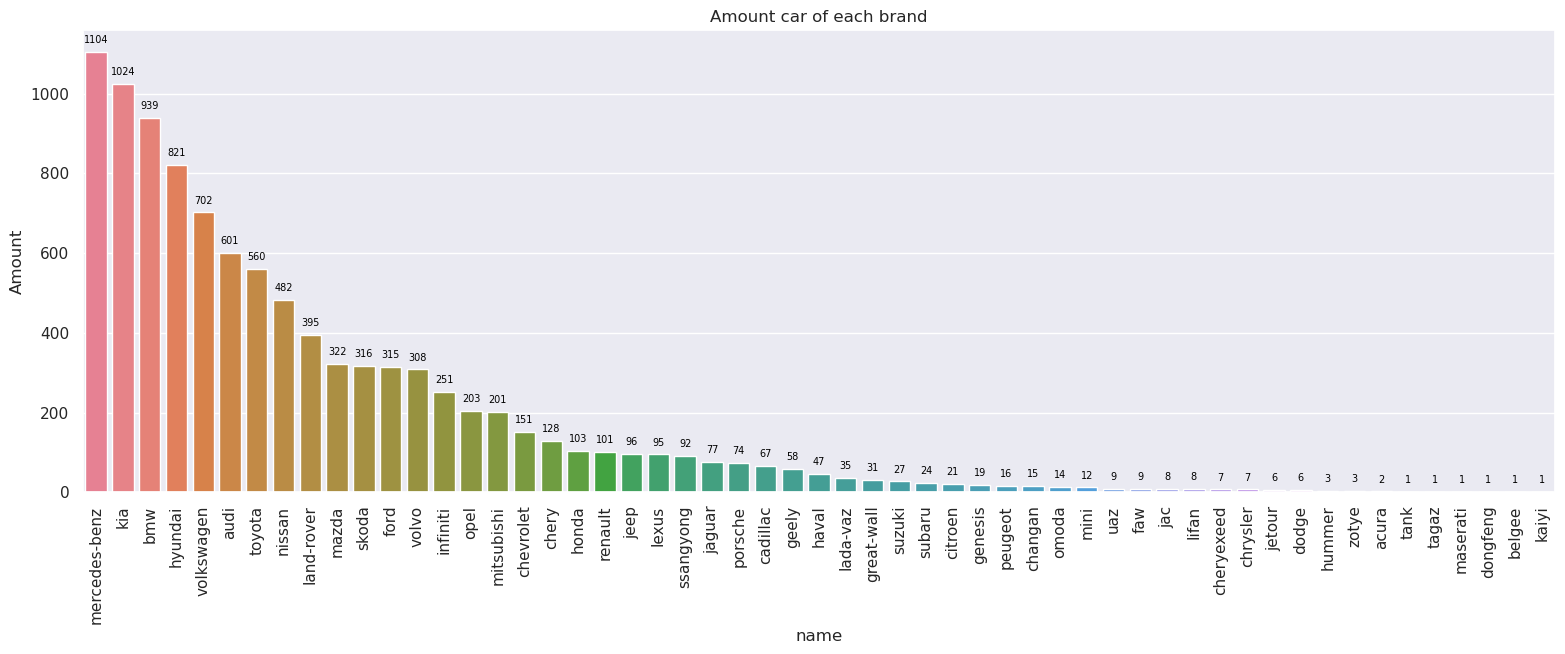

In [84]:
plt.figure(figsize=(19,6))
ax = sns.barplot(data = name_count, x = 'name', y = 'price', hue = 'name' )
plt.xticks(rotation = 90)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=7, color='black', xytext=(0, 5), textcoords='offset points')
plt.ylabel('Amount')
plt.title('Amount car of each brand')
plt.show();

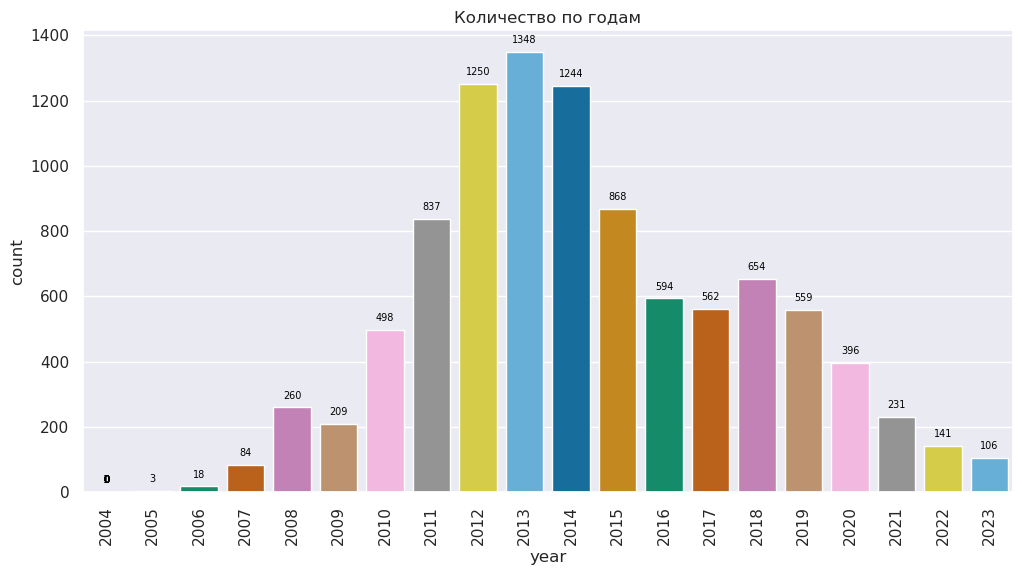

In [85]:
#year
#first group and count eachn year and list full year started min to max
year_counts = df['year'].value_counts()
year_sorted_df = year_counts.reset_index().sort_values(by ='year') #change to dataframe and sort
all_years = list(range(year_sorted_df['year'].min(), year_sorted_df['year'].max())) #make array full year min to max
df_full = pd.DataFrame({'year': all_years}) #create dataframe (column year full)
df_full = df_full.merge(year_sorted_df, on='year', how='left') #merge 2 dataframe
df_full['Count'] = df_full['count'].fillna(0).astype(int) #fill NaN by 0
df_full.drop(columns=['count']) #drop count column
plt.figure(figsize=(12,6))
ax = sns.barplot(data = df_full, x = 'year', y = 'count', palette = 'colorblind', hue = 'year')
plt.xticks(rotation = 90)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=7, color='black', xytext=(0, 5), textcoords='offset points')
plt.legend().set_visible(False) # tắt chú thích
plt.title('Количество по годам')
plt.show();

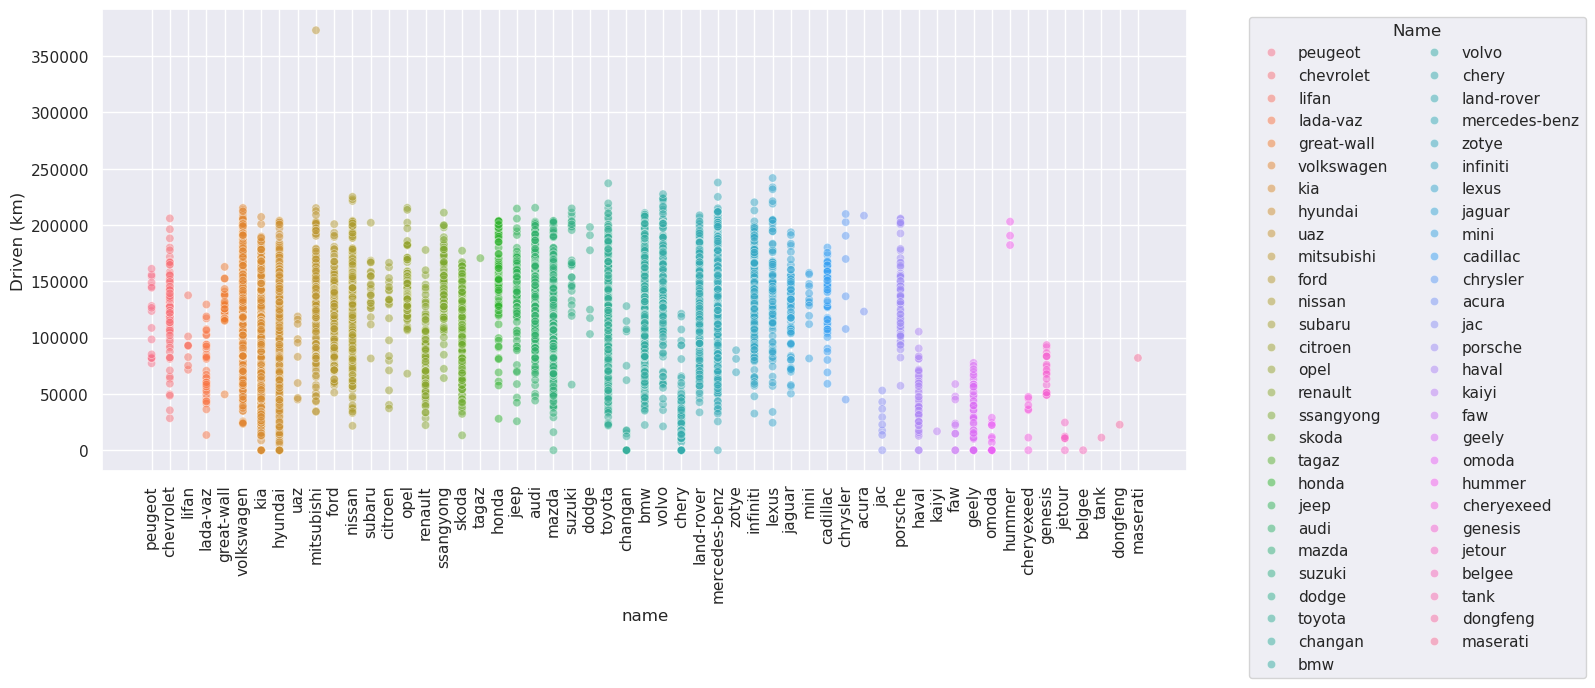

In [86]:
plt.figure(figsize=(14,6))
sns.scatterplot(data = df,  x = 'name', y = 'mileage', hue = 'name', alpha = 0.5)
plt.legend(title="Name", bbox_to_anchor=(1.05, 1), loc='upper left',ncol = 2) #chú thích ra ngoài và 2 cột
plt.xticks(rotation = 90)
plt.ylabel('Driven (km)')
plt.show();

## Корреляция

In [66]:
corr = df[['volume', 'mileage', 'price', 'year', 'power', 'age']].corr()

In [70]:
corr

,volume,mileage,price,year,power,age
volume,1.000000,0.293875,0.338396,-0.301244,0.862301,0.301244
mileage,0.293875,1.000000,-0.469223,-0.983659,0.203461,0.983659
price,0.338396,-0.469223,1.000000,0.473645,0.436797,-0.473645
year,-0.301244,-0.983659,0.473645,1.000000,-0.211535,-1.000000
power,0.862301,0.203461,0.436797,-0.211535,1.000000,0.211535
age,0.301244,0.983659,-0.473645,-1.000000,0.211535,1.000000


In [67]:
x_age = df.age
y_mileage = df.mileage
x_power = df.power
y_volume = df.volume

In [68]:
 
def Pearson_correlation(X,Y):
    if len(X)==len(Y):
        Sum_xy = sum((X-X.mean())*(Y-Y.mean()))
        Sum_x_squared = sum((X-X.mean())**2)
        Sum_y_squared = sum((Y-Y.mean())**2)       
        corr = Sum_xy / np.sqrt(Sum_x_squared * Sum_y_squared)
    return corr
             
print('Кореляция Возраста машины и Пробега')
print(Pearson_correlation(x_age, y_mileage))    
print(Pearson_correlation(x_age, x_age))
print('Кореляция Мощьности и обьема двигатля')
print(Pearson_correlation(x_power, y_volume))    
print(Pearson_correlation(x_power, x_power))

Кореляция Возраста машины и Пробега
0.9836585351725121
1.0
Кореляция Мощьности и обьема двигатля
0.8623007599482589
1.0


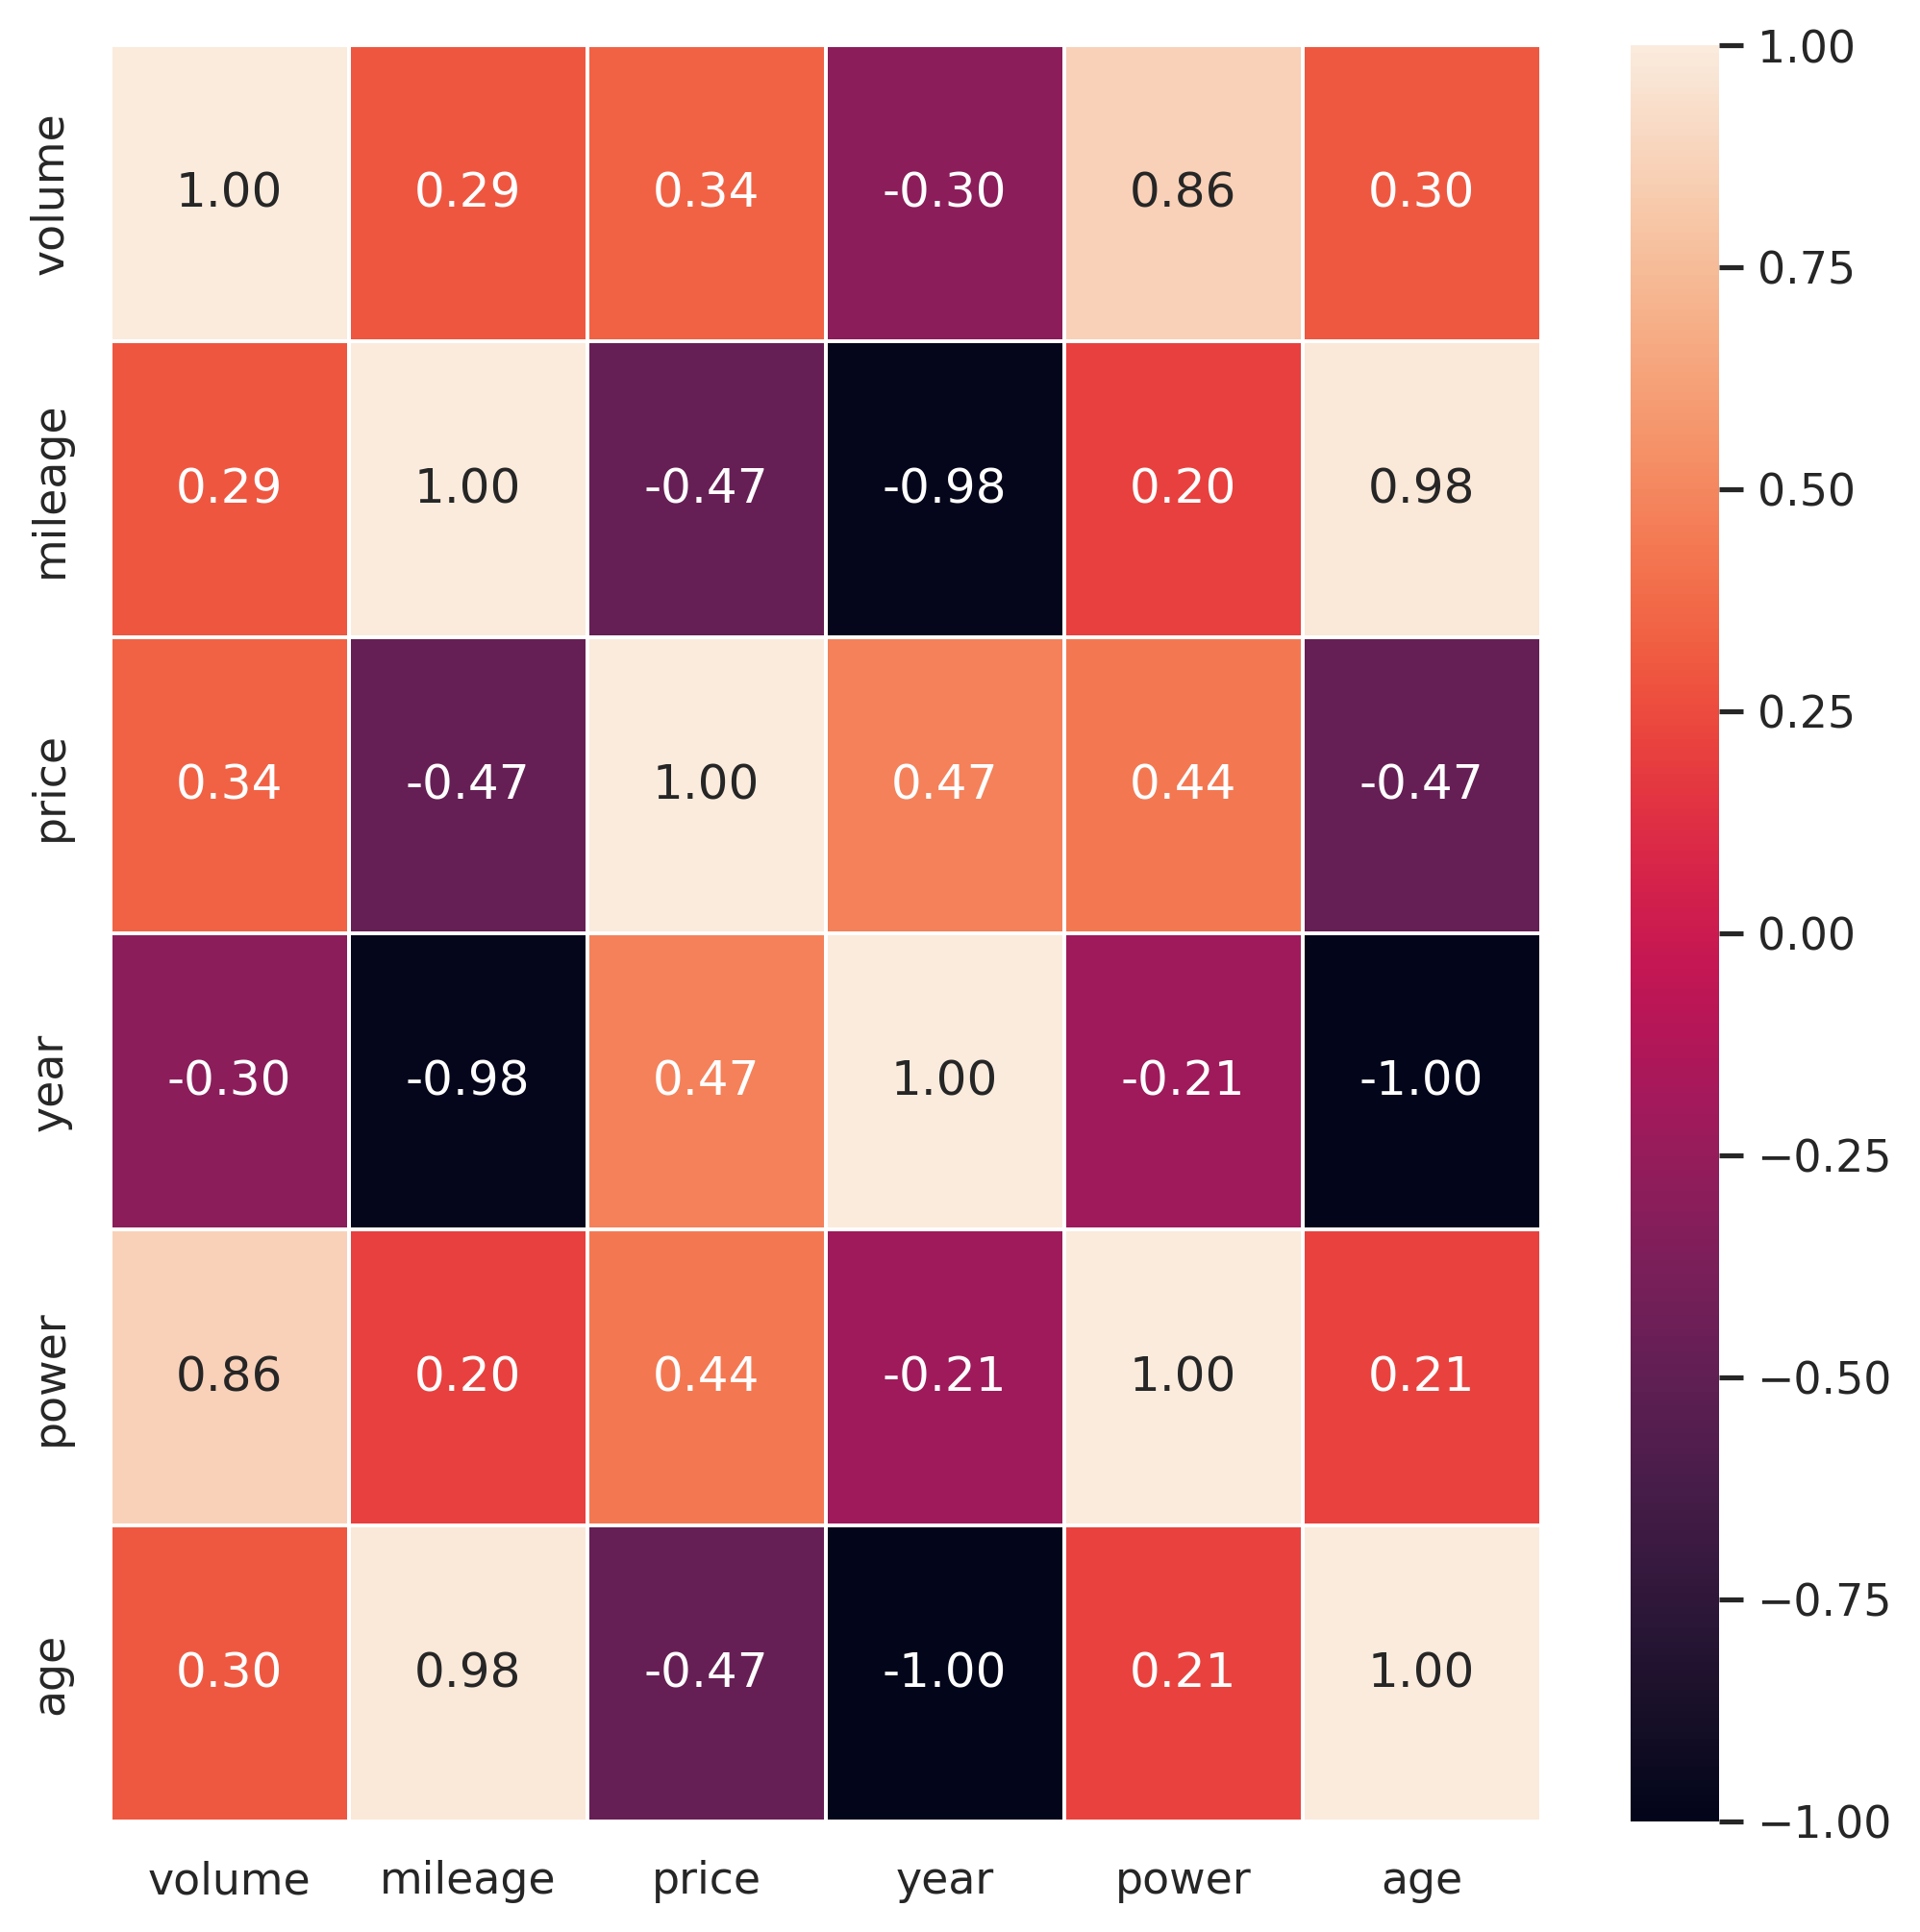

In [69]:
plt.figure(figsize=(8,8), dpi =300)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
plt.show()

## Линейная регрессия

In [87]:
columns_feature = ['name','model','transmission','owners','drive', 'body_type', 'engine']
for column in columns_feature:
    df[column] = df[column].astype('category')

In [90]:
encoder = LabelEncoder()
category_columns = df.select_dtypes(include='category').columns.tolist()
for category in category_columns:
    df[category] = encoder.fit_transform(df[category])

In [94]:
df.head()

,name,price,year,transmission,mileage,volume,power,engine,body_type,drive,owners,age,model
0,41,299000,2010,1,145543,1.6,120,0,11,1,2,14,9
1,8,399000,2012,3,180066,1.6,109,0,8,1,2,12,82
2,32,399000,2013,3,137622,1.8,128,0,1,1,1,11,336
3,29,419000,2015,3,117128,1.6,105,0,9,1,2,9,184
4,17,419000,2013,3,140844,2.4,127,0,1,2,2,11,156


In [106]:
X = df.drop(columns = ['price'])
y = df['price']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [108]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [109]:
# regression coefficients
print('Coefficients: ', reg.coef_)
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))


Coefficients:  [ 1.40744528e+03  6.15336931e+04 -2.55548293e+04 -1.03430774e-01
  5.04106196e+04  4.58960709e+03  2.65527084e+05 -7.15580835e+03
  4.30307967e+04  4.01635026e+04 -6.15336931e+04 -5.27731416e+02]
Variance score: 0.6601850232102711


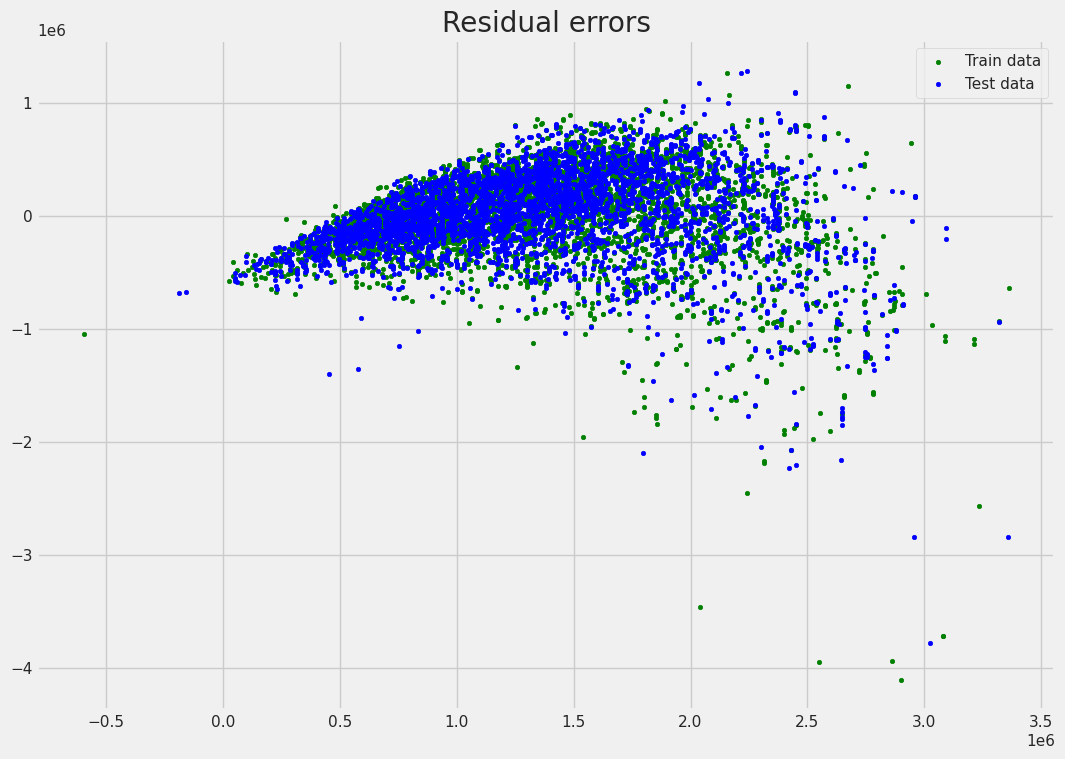

In [119]:
# plot for residual error

# setting plot style
plt.style.use('fivethirtyeight')

# plotting residual errors in training data
plt.scatter(reg.predict(X_train),
            reg.predict(X_train) - y_train,
            color="green", s=10,
            label='Train data')

# plotting residual errors in test data
plt.scatter(reg.predict(X_test),
            reg.predict(X_test) - y_test,
            color="blue", s=10,
            label='Test data')

# plotting line for zero residual error
plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)

# plotting legend
plt.legend(loc='upper right')

# plot title
plt.title("Residual errors")

# method call for showing the plot
plt.show()

In [122]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=40)

In [126]:
rf_clf = RandomForestClassifier(random_state=40)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=40)

In [127]:
y_pred = rf_clf.predict(X_test)

In [130]:
y_pred

array([ 819000, 1729000, 1779000, ..., 1749000,  559000, 1439000])

In [129]:
y_test

2340     849000
7624    1649000
8087    1799000
8056    1799000
5798    1289000
         ...   
7704    1669000
7455    1599000
8284    1889000
369      599000
6718    1429000
Name: price, Length: 1985, dtype: int64

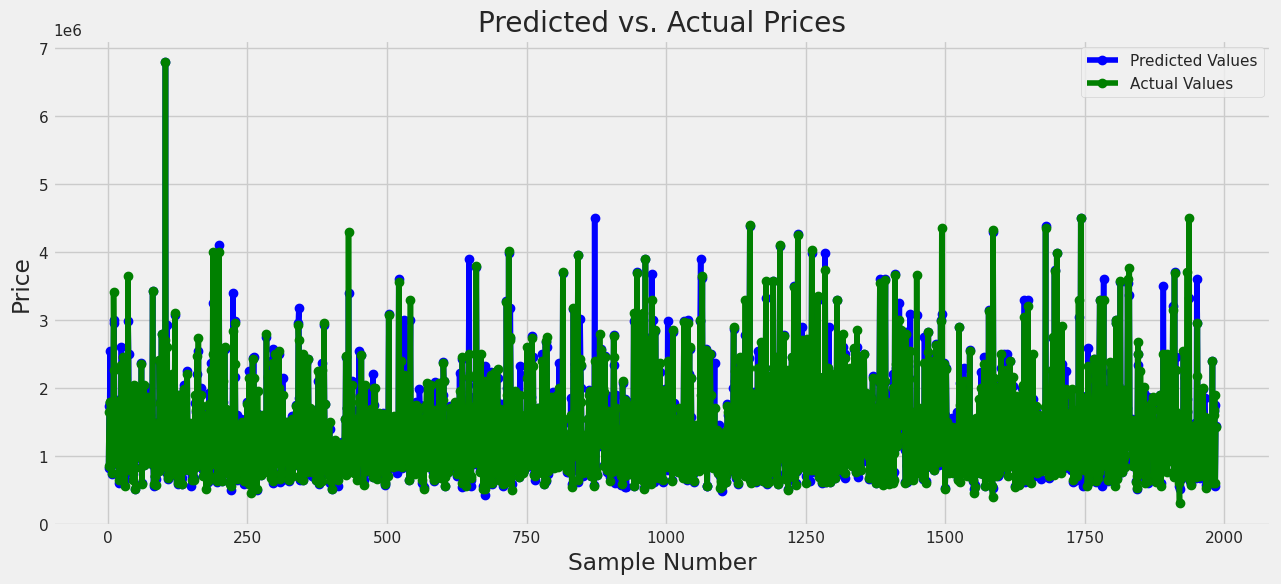

In [131]:
plt.figure(figsize=(14, 6))
plt.plot(np.arange(1, len(y_pred) + 1), y_pred, marker='o', linestyle='-', color='blue', label='Predicted Values')
plt.plot(np.arange(1, len(y_test) + 1), y_test.reset_index()['price'], marker='o', linestyle='-', color='green', label='Actual Values')
plt.xlabel("Sample Number") # Added x-axis label
plt.ylabel("Price") # Added y-axis label
plt.title("Predicted vs. Actual Prices") # Added title
plt.legend() # Added legend
plt.grid(True) # Added grid for better readability
plt.show()